In [2]:
from ngauge import Neuron
from glob import glob

In [3]:
files = [ Neuron.from_swc(x) for x in glob('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/axon_geometry/data/brain1/segments_swc/*.swc') ]

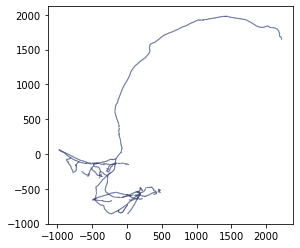

In [7]:
# Select a neuron
file = files[0]

# Plot 
fig = file.plot(fig=None, ax=None, color=(52/256, 66/256, 123/256) )